# Install requirements and Imports
1. Run the below cell in order to **correct install all the libraries needed**,  and wait for its completion (see the comment below)

In [ ]:
################################################################################
##### WAIT FOR COMPLETE EXECUTION OF THIS CELL BEFORE RUNNING THE FOLLOWING ONES
################################################################################
%%capture
! pip uninstall --yes numpy
! pip install numpy==1.19.5

import os
os.kill(os.getpid(), 9)

2. Run this cell, **after the completion of the one above it**

In [1]:
%%capture
! pip install tensorflow==2.4.1
! pip install nengo==3.1.0
! pip install nengo-dl==3.4.0


3. Import all the **libraries**

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import os
import gdown
import sklearn
from sklearn.cluster import KMeans

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  LSTM, Dropout, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tensorflow.keras.losses import categorical_crossentropy

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from gdown.download_folder import download_and_parse_google_drive_link
from google.colab import drive

import scipy.cluster.hierarchy as sch
import pickle
from sklearn.decomposition import PCA
import nengo
from tensorflow.keras.layers import BatchNormalization
import nengo_dl

from nengo.utils.filter_design import cont2discrete
import sympy
from urllib.request import urlretrieve

# Download and prepare WISDM dataset

In [3]:
print("Download the WISDM Dataset: \n")
!gdown --fuzzy https://drive.google.com/file/d/1CroZq_bSfie_qsX7svdWWnZsnwNlvhjH/view?usp=sharing

Download the WISDM Dataset: 

Downloading...
From: https://drive.google.com/uc?id=1CroZq_bSfie_qsX7svdWWnZsnwNlvhjH
To: /content/data_watch_40.npz
100% 368M/368M [00:03<00:00, 106MB/s]


## Dataset functions
Functions useful in order to **load correctly the wisdm dataset**

In [4]:
def load_dataset4exploration(file_name):
    filepath = os.path.join('./',file_name+'.npz')
    a = np.load(filepath)
    return (a['arr_0'], a['arr_1'], a['arr_2'], a['arr_3'], a['arr_4'], a['arr_5'])

In [5]:
def labels_identification_wisdm2():
    act_map = {'A': 'walking', 'B': 'jogging', 'C': 'stairs', 'D': 'sitting', 'E': 'standing', 'M': 'kicking', 'P': 'dribbling', 'O': 'catch', 'F': 'typing',
        'Q': 'writing', 'R': 'clapping', 'G': 'teeth', 'S': 'folding', 'J': 'pasta', 'H': 'soup', 'L': 'sandwich', 'I': 'chips', 'K': 'drinking', }
    labels = list(act_map.values())[0:18]
    return labels

# Load the Dataset & inspect the structure

In [6]:
datafile = "data_watch_40"
(x_train, x_val, x_test, y_train_oh, y_val_oh, y_test_oh) = load_dataset4exploration(datafile)

n_classes = len(y_train_oh[0])

y_train = np.argmax(y_train_oh, axis=-1)
y_val = np.argmax(y_val_oh, axis=-1)
y_test = np.argmax(y_test_oh, axis=-1)

labels = labels_identification_wisdm2()
labels_dict = {}

for idx, label in enumerate(labels):
  if label not in labels_dict.keys():
    labels_dict[label] = idx

print("Training set dimensions: {}".format(x_train.shape))
print("Validation set dimensions: {}".format(x_val.shape))
print("Test set dimensions: {}".format(x_test.shape))

print("\n")

print("Dimensions of a single sample: {}".format(x_train[0].shape))
print("\twhere {}/20 gives the temporal length (in seconds) of the signal \n\twhile {} represents the 3-axes accelerometer and gyroscope data.".format(x_train[0].shape[0],x_train[0].shape[1]))

Training set dimensions: (110807, 40, 6)
Validation set dimensions: (36936, 40, 6)
Test set dimensions: (36936, 40, 6)


Dimensions of a single sample: (40, 6)
	where 40/20 gives the temporal length (in seconds) of the signal 
	while 6 represents the 3-axes accelerometer and gyroscope data.


# K-Means Clustering
We have choose to perform a K-Means clustering, with **5 different values for K**, in particular: K = 4, 5, 6, 7 and 8. Then we have collected all the results, for each value of K, in terms of:

*   K-Means representation
*   Global score
*   Global median
*   Classes median

If you want to load the K-Means representation from an external file, **you can set the variable outcomes_link with the link of your .pkl gdrive file, if any**

In [7]:
outcomes_link = "https://drive.google.com/file/d/1oPVs5BOJzlbHHnlnWBdvzZKv4K593ZDd/view?usp=sharing"
list_clusters = [4, 5, 6, 7, 8]
outcomes = {} #data structure, {'num_cluster': {'k_means': kmeans, 
                                #'global_score': float, 
                                #'global_median': float,
                                #'classes_median': [float, ...]}}
x_train_2d = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])

if not outcomes_link:
  for n_clusters in list_clusters:
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(x_train_2d)

    outcomes[n_clusters] = {}
    outcomes[n_clusters]['kmeans'] = kmeans
    outcomes[n_clusters]['global_score'] = 0
    outcomes[n_clusters]['global_median'] = 0
    outcomes[n_clusters]['classes_median'] = []
    
    np_labels = np.array(y_train)
    np_kmeans_labels = np.array(kmeans.labels_)

    cluster_indexes = {}
    cluster_labels = {}
    cluster = {}

    for clst in range(n_clusters):
      cluster_indexes[clst] = [True if l == clst else False for l in np_kmeans_labels]
      cluster_labels[clst] = np_labels[cluster_indexes[clst]]
      cluster[clst] = []
      for idx, _ in enumerate(labels_dict.values()):
        cluster[clst].append(np.sum([1 for l in cluster_labels[clst] if l == idx]))
      #print(f"cluster {clst} -> most representative class is {cluster[clst].index(max(cluster[clst]))} with: {max(cluster[clst]) / cluster_labels[clst].shape[0] * 100}% of samples for this cluster")

    classes_scores = []
    for idx, _ in enumerate(labels_dict.values()):
      scores = []
      for clst in range(n_clusters):
        num_class_kmeans_labels = np.sum([1 for l in np_labels if l == idx])
        scores.append(cluster[clst][idx] / num_class_kmeans_labels)
      max_score = max(scores)
      for i in range(len(scores)):
        scores[i] = max_score - scores[i]
      scores.sort()
      outcomes[n_clusters]['classes_median'].append(scores[int(len(scores)/2)])
      classes_scores.append(sum(scores) / len(scores))
    classes_scores.sort()
    outcomes[n_clusters]['global_median'] = classes_scores[int(len(classes_scores)/2)]
    outcomes[n_clusters]['global_score'] = sum(classes_scores)

    #Save the outcomes into a pkl file
    pickle.dump(outcomes, open("outcomes.pkl", "wb"))
else:
  print("Download the outcomes file: \n")
  !gdown --fuzzy {outcomes_link} -O "outcomes.pkl"

outcomes = pickle.load(open("outcomes.pkl", "rb"))

Download the outcomes file: 

Downloading...
From: https://drive.google.com/uc?id=1oPVs5BOJzlbHHnlnWBdvzZKv4K593ZDd
To: /content/outcomes.pkl
100% 2.28M/2.28M [00:00<00:00, 223MB/s]


## Choose of the best value of K and Data Visualization (LDA applied)
We have performed the **Pareto Front evaluation for our parameters** (global score, global median, ecc.) in order to choose **which K is the best one**. After this, we have plotted the graph related to the clustering **after the application of LDA**, which could help us to visualize better the separations

K = 4 -> Global score: 5.796171112085835 - Global median: 0.364826498422713
K = 5 -> Global score: 6.159698034360989 - Global median: 0.3826308255129633
K = 6 -> Global score: 6.444478193823542 - Global median: 0.369200996765813
K = 7 -> Global score: 6.201346274350557 - Global median: 0.34110007639419404
K = 8 -> Global score: 6.0393714220843355 - Global median: 0.3423135040559885

The best choices for the number of clusters are K = 6 and K = 5

Scatter of the Dataset


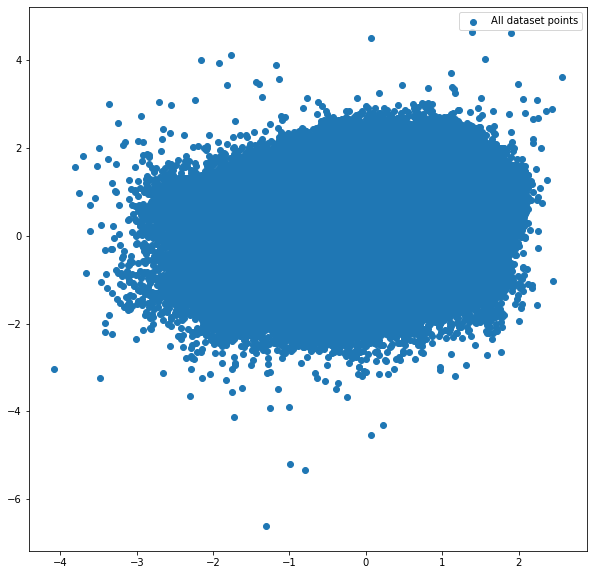


Scatter of the Clusters K = 6


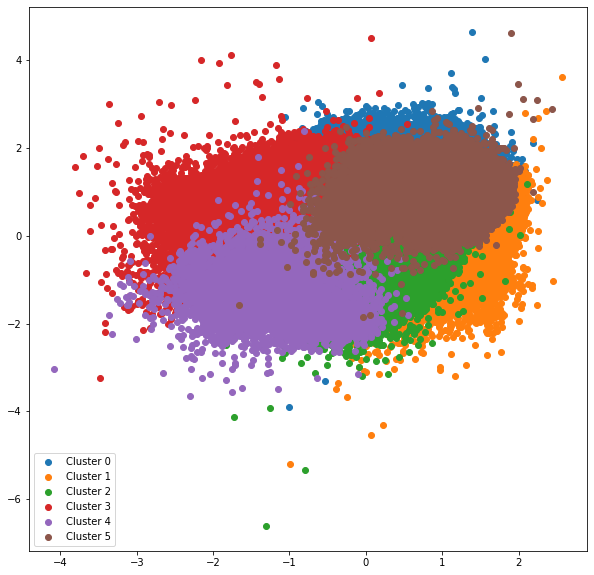


Scatter of the Clusters K = 5


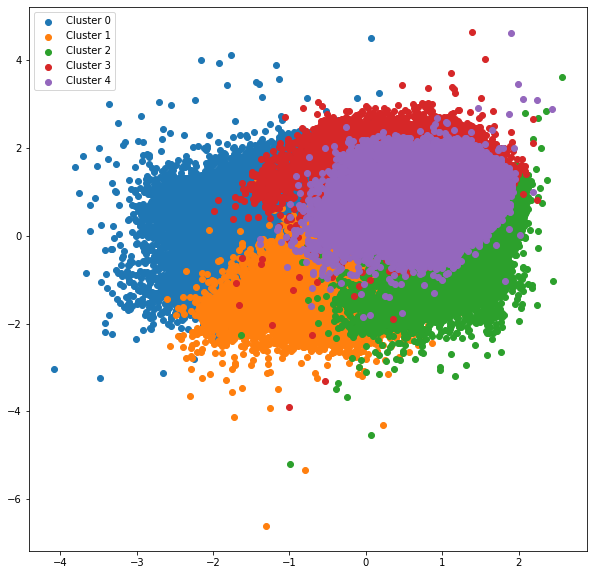

In [8]:
K_score = -1
K_median = -1
max_score = -1
max_median = -1 

for key in outcomes.keys():
  if outcomes[key]['global_score'] > max_score:
    max_score = outcomes[key]['global_score']
    K_score = key
  if outcomes[key]['global_median'] > max_median:
    max_median = outcomes[key]['global_median']
    K_median = key
  print(f"K = {key} -> Global score: {outcomes[key]['global_score']} - Global median: {outcomes[key]['global_median']}")

clf = LDA()
x_train_2d_lda = clf.fit_transform(x_train_2d, y_train)

print(f"\nThe best choices for the number of clusters are K = {K_score} and K = {K_median}")

plt.figure(figsize=(10, 10))
print("\nScatter of the Dataset")
plt.scatter(x_train_2d_lda[:,0], x_train_2d_lda[:,1], label='All dataset points')
plt.legend()
plt.show()

u_labels = np.unique(outcomes[K_score]['kmeans'].labels_)
print(f"\nScatter of the Clusters K = {K_score}")
plt.figure(figsize=(10, 10))
for l in u_labels:
  plt.scatter(x_train_2d_lda[outcomes[K_score]['kmeans'].labels_==l , 0] , x_train_2d_lda[outcomes[K_score]['kmeans'].labels_==l , 1] , label='Cluster '+str(l))
plt.legend()
plt.show()

if K_score != K_median:
  u_labels = np.unique(outcomes[K_median]['kmeans'].labels_)
  print(f"\nScatter of the Clusters K = {K_median}")
  plt.figure(figsize=(10, 10))
  for l in u_labels:
    plt.scatter(x_train_2d_lda[outcomes[K_median]['kmeans'].labels_==l , 0] , x_train_2d_lda[outcomes[K_median]['kmeans'].labels_==l , 1] , label='Cluster '+str(l))
  plt.legend()
  plt.show()


### Useful computations for the clustering
After the clustering we have noticed that the **assignments for each class are the same even if we have different numbers of K**. It means that, if we put:

1. *K = 6* we have **two clusters without classes inside it**
2. *K = 5* we have **one cluster without classes inside it** 

For this reason we have choose to set **K = 4 by default**. If you want to load the labels associated to a differnt clustering, you can change the parameter **y_train_cluster_link** and **y_test_cluster_link** in order to load these from an external file

In [9]:
y_train_cluster_link = "https://drive.google.com/file/d/1-ygJCaUCVxLYo_oeMNQokodpjaugabae/view?usp=sharing"
y_test_cluster_link = "https://drive.google.com/file/d/1UFYX41wwEjwTABy0pKQsdxwtfeaFjbID/view?usp=sharing"

K = 4

np_labels = np.array(y_train)
np_kmeans_labels = np.array(outcomes[K]['kmeans'].labels_)

cluster_indexes = {}
cluster_labels = {}
cluster = {}

all_labels = []

for clst in range(K):
  cluster_indexes[clst] = [True if l == clst else False for l in np_kmeans_labels]
  cluster_labels[clst] = np_labels[cluster_indexes[clst]]
  all_labels = np.concatenate((all_labels, cluster_labels[clst]))
  cluster[clst] = []
  for idx, _ in enumerate(labels_dict.values()):
    cluster[clst].append(np.sum([1 for l in cluster_labels[clst] if l == idx]))

class_clusters = {}
for idx, _ in enumerate(labels_dict.values()):
  for clst in range(K):
    if idx not in class_clusters.keys():
      class_clusters[idx] = [0, 0]
    if class_clusters[idx][1] < (cluster[clst][idx] / np.sum([1 for l in all_labels if l == idx]) * 100):
      class_clusters[idx] = [clst, cluster[clst][idx] / np.sum([1 for l in all_labels if l == idx]) * 100]

y_train_cluster = []
y_test_cluster = []

if not y_train_cluster_link:
  for label in y_train:
    y_train_cluster.append(class_clusters[label][0])
  pickle.dump(y_train_cluster, open("y_train_cluster.pkl", "wb"))
else:
  print("Download the y_train_cluster file: \n")
  !gdown --fuzzy {y_train_cluster_link} -O "y_train_cluster.pkl"
  y_train_cluster = pickle.load(open("y_train_cluster.pkl", "rb"))

if not y_test_cluster_link:
  for label in y_test:
    y_test_cluster.append(class_clusters[label][0])
  pickle.dump(y_test_cluster, open("y_test_cluster.pkl", "wb"))
else:
  print("\nDownload the y_test_cluster file: \n")
  !gdown --fuzzy {y_test_cluster_link} -O "y_test_cluster.pkl"
  y_test_cluster = pickle.load(open("y_test_cluster.pkl", "rb"))

Download the y_train_cluster file: 

Downloading...
From: https://drive.google.com/uc?id=1-ygJCaUCVxLYo_oeMNQokodpjaugabae
To: /content/y_train_cluster.pkl
100% 222k/222k [00:00<00:00, 111MB/s]

Download the y_test_cluster file: 

Downloading...
From: https://drive.google.com/uc?id=1UFYX41wwEjwTABy0pKQsdxwtfeaFjbID
To: /content/y_test_cluster.pkl
100% 74.0k/74.0k [00:00<00:00, 81.2MB/s]


# LSTM
Run this code in order to **fit the LSTM to the training dataset**. If you have a pretrained LSTM model you can load this one by **changing the lstm_model_path variable with the path of the model on your own gdrive** 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM_1 (LSTM)                (None, 40, 256)           269312    
_________________________________________________________________
Dropout_1 (Dropout)          (None, 40, 256)           0         
_________________________________________________________________
LSTM_2 (LSTM)                (None, 128)               197120    
_________________________________________________________________
Dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 4)                 516       
Total params: 466,948
Trainable params: 466,948
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
887/887 [==============================] - 21s 18ms/step - loss: 0.9574 - accuracy: 0.6582 - val_loss: 0.

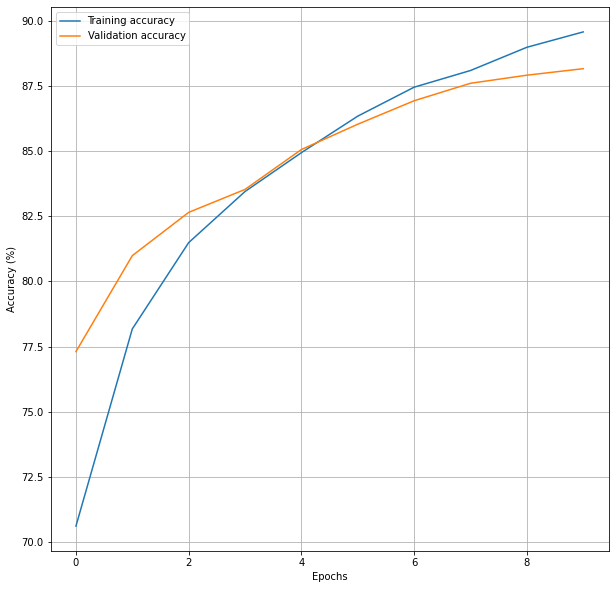

INFO:tensorflow:Assets written to: lstm_model/assets


INFO:tensorflow:Assets written to: lstm_model/assets


In [27]:
lstm_model_path = ""#"/content/drive/MyDrive/Polito/\"Machine Learning in Application\"/Project/lstm_model"#"/content/drive/MyDrive/MLIA/Project/lstm_model"

y_tr_cluster_oh = []
for label in y_train_cluster:
  temp = [0., 0., 0., 0.]
  temp[label] = 1.
  y_tr_cluster_oh.append(temp)
y_tr_cluster_oh = np.array(y_tr_cluster_oh)

y_te_cluster_oh = []
for label in y_test_cluster:
  temp = [0., 0., 0., 0.]
  temp[label] = 1.
  y_te_cluster_oh.append(temp)
y_te_cluster_oh = np.array(y_te_cluster_oh)

if not lstm_model_path:
  timesteps = len(x_train[0])
  input_dim = len(x_train[0][0])
  model = Sequential()

  model.add(LSTM(256, return_sequences=True,input_shape=(timesteps, input_dim),name='LSTM_1'))
  model.add(Dropout(0.6,name='Dropout_1'))
  model.add(LSTM(128,recurrent_regularizer=l2(0.005),input_shape=(timesteps, input_dim),name='LSTM_2'))
  model.add(Dropout(0.2,name='Dropout_2'))
  model.add(Dense(4, activation='softmax'))

  optimizer = Adam()

  model.compile(loss=categorical_crossentropy,
                optimizer=optimizer,
                metrics=['accuracy'])
  
  model.summary()

  x_train_cluster = x_train[0:int(x_train.shape[0]*0.8)]
  y_train_cluster_oh = y_tr_cluster_oh[0:int(x_train.shape[0]*0.8)]
  x_val_cluster = x_train[int(x_train.shape[0]*0.8):]
  y_val_cluster_oh = y_tr_cluster_oh[int(x_train.shape[0]*0.8):]

  history = model.fit(x_train_cluster,
                      y_train_cluster_oh,
                      validation_data=(x_val_cluster, y_val_cluster_oh),
                      batch_size=100,
                      epochs=10)
  
  print("\n")
  plt.figure(figsize=(10, 10))
  plt.plot(np.round(np.array(history.history["accuracy"])*100,2))
  plt.plot(np.round(np.array(history.history["val_accuracy"])*100,2))
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy (%)")
  plt.legend(["Training accuracy", "Validation accuracy"])
  plt.grid()
  plt.show()
  
  model.save("lstm_model")
else:
  print("Load the model from gdrive: \n")
  drive.mount('/content/drive')
  !cp -r {lstm_model_path} -d "lstm_model"
  model = keras.models.load_model("lstm_model")
  model.summary()

In [11]:
print("Evaluate the LSTM model: \n")
model.evaluate(x_test, y_te_cluster_oh, batch_size=100)

Evaluate the LSTM model: 

370/370 [==============================] - 13s 5ms/step - loss: 0.3329 - accuracy: 0.8818


[0.332887202501297, 0.8818497061729431]

# Feature Selection functions
Useful functions for the **application of PCA**  to our dataset

In [12]:
def max_axis_tick(axis_var):
    if np.round(np.nanmax(axis_var),5) > 1:
        if len(str(int(np.nanmax(axis_var)))) > 2:
            max_tick = np.round(int(np.nanmax(axis_var)) + 10**(len(str(int(np.nanmax(axis_var))))-2), -len(str(int(np.nanmax(axis_var))))+2)
        elif len(str(int(np.nanmax(axis_var)))) == 2:
            max_tick = np.round(int(np.nanmax(axis_var)) + 10, -1)
        else:
            max_tick = int(np.nanmax(axis_var)) + 1
    else:
        max_tick = np.round(np.nanmax(axis_var), 2) 
    return max_tick

In [13]:
def pca_wisdm(wisdm_train, wisdm_test, cluster):
  pca = PCA()
  pca_x_train = pca.fit_transform(wisdm_train)

  exp_var_ratio = pca.explained_variance_ratio_
  cumulative_exp_var_ratio = np.cumsum(exp_var_ratio)

  pca_reduced = PCA(n_components=0.95)
  
  pca_x_train_2d_reduced = pca_reduced.fit_transform(wisdm_train)
  pca_x_test_2d_reduced = pca_reduced.transform(wisdm_test)

  x = range(0,len(exp_var_ratio[:pca_reduced.n_components_]))
  y1 = exp_var_ratio[:pca_reduced.n_components_]
  y2 = cumulative_exp_var_ratio[:pca_reduced.n_components_]

  print(f"\nCluster {cluster} - {int(0.95*100)}% variance with {pca_reduced.n_components_} components out of {pca.n_components_}")

  return pca_x_train_2d_reduced, pca_x_test_2d_reduced, (x, y1, y2)

In [14]:
def plot_pca_wisdm(x, y1, y2):
  fig, ax1 = plt.subplots(figsize=(7, 5.25))

  color1 = 'navy'
  ax1.set_xlabel('Principal component index')
  ax1.set_ylabel('Individual explained variance', color=color1)
  ax1.bar(x, y1, alpha=0.5, align='center', color=color1)
  ax1.tick_params(axis='y', labelcolor=color1)

  ax2 = ax1.twinx() 
  color2 = 'maroon'
  ax2.set_ylabel('Cumulative explained variance', color=color2)
  ax2.step(x, y2, where='mid', color=color2)
  ax2.tick_params(axis='y', labelcolor=color2)

  ax1.set_facecolor('w')
  ax1.grid(False)
  ax2.grid(False)

  lim_y1 = max_axis_tick(y1)
  lim_y2 = max_axis_tick(y2)
  ax1.set_yticks(np.linspace(0, lim_y1, 11))
  ax2.set_yticks(np.linspace(0, lim_y2, 11))
  ax1.set_ylim(0, lim_y1*1.05)
  ax2.set_ylim(0, lim_y2*1.05)

  fig.tight_layout()

  plt.show()

## Cluster Separation
The commented code below, is used in order to produce the **predictions for the test set** according the application of the LSTM model


In [28]:
test_clusters_oh = model.predict(x_test)
test_clusters = np.argmax(test_clusters_oh, axis=-1)

The temporal dimensions for each clusters, **after the application of PCA with 95% variance preserved**, are:

*   *5 for the first cluster*
*   *82 for the second cluster*
*   *69 for the third cluster*
*   *113 for the fourth cluster*


Cluster 0 - 95% variance with 5 components out of 240


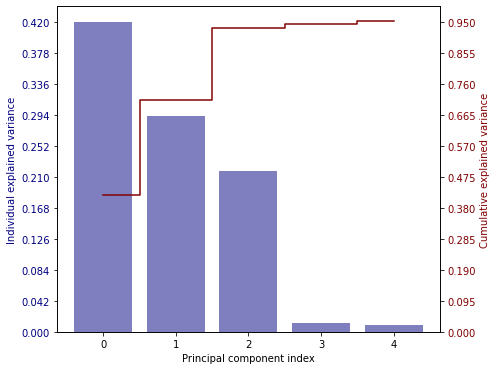


Cluster 1 - 95% variance with 82 components out of 240


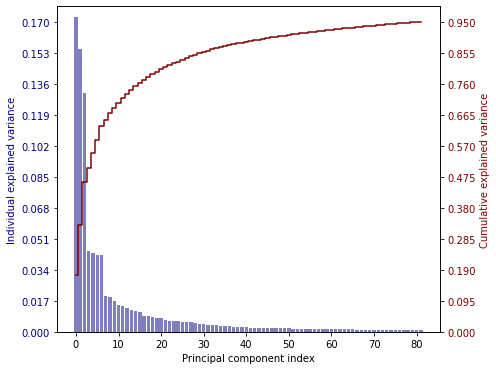


Cluster 2 - 95% variance with 69 components out of 240


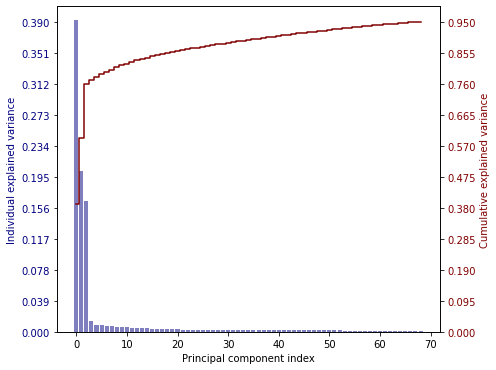


Cluster 3 - 95% variance with 113 components out of 240


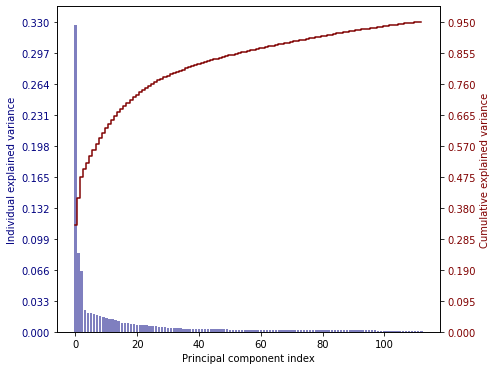

In [33]:
cluster_dict = {}
for cls in class_clusters.keys():
  if class_clusters[cls][0] not in cluster_dict.keys():
    cluster_dict[class_clusters[cls][0]] = []
  cluster_dict[class_clusters[cls][0]].append(cls)

separate_datasets = {} #1: {data: [], labels: [], classes: [], transformed: []}, ...}

for clst in range(K):
  separate_datasets[clst] = {}
  mask_tr = [True if label in cluster_dict[clst] else False for label in y_train]
  mask_te = [True if label == clst else False for label in test_clusters]

  separate_datasets[clst]['data'] = x_train[mask_tr]
  separate_datasets[clst]['labels'] = y_train[mask_tr]
  separate_datasets[clst]['classes'] = cluster_dict[clst]

  separate_datasets[clst]['test_data'] = x_test[mask_te]
  separate_datasets[clst]['test_labels'] = y_test[mask_te]

  data_tr = separate_datasets[clst]['data'].reshape(separate_datasets[clst]['data'].shape[0], separate_datasets[clst]['data'].shape[1]*separate_datasets[clst]['data'].shape[2])
  data_te = separate_datasets[clst]['test_data'].reshape(separate_datasets[clst]['test_data'].shape[0], separate_datasets[clst]['test_data'].shape[1]*separate_datasets[clst]['test_data'].shape[2])
  labels = separate_datasets[clst]['labels']
  
  transformed_data_train, transformed_data_test, (x, y1, y2) = pca_wisdm(data_tr, data_te, clst)
    
  plot_pca_wisdm(x, y1, y2)
  separate_datasets[clst]['transformed'] = transformed_data_train
  separate_datasets[clst]['transformed_test'] = transformed_data_test
  
  separate_datasets[clst]['transformed_test'] = separate_datasets[clst]['transformed_test'].reshape((separate_datasets[clst]['transformed_test'].shape[0], -1, 1))
  separate_datasets[clst]['transformed'] = separate_datasets[clst]['transformed'].reshape((separate_datasets[clst]['transformed'].shape[0], -1, 1))

pickle.dump(separate_datasets, open("separate_datasets.pkl", "wb"))



# Classification (LMU)
LMUCell used to **perform the simulation**

In [30]:
class LMUCell(nengo.Network):
    def __init__(self, units, order, theta, input_d, **kwargs):
        super().__init__(**kwargs)

        Q = np.arange(order, dtype=np.float64)
        R = (2 * Q + 1)[:, None] / theta
        j, i = np.meshgrid(Q, Q)

        A = np.where(i < j, -1, (-1.0) ** (i - j + 1)) * R
        B = (-1.0) ** Q[:, None] * R
        C = np.ones((1, order))
        D = np.zeros((1,))

        A, B, _, _, _ = cont2discrete((A, B, C, D), dt=1.0, method="zoh")

        with self:
            nengo_dl.configure_settings(trainable=None)

            self.x = nengo.Node(size_in=input_d)
            self.u = nengo.Node(size_in=1)
            self.m = nengo.Node(size_in=order)
            self.h = nengo_dl.TensorNode(tf.nn.tanh, shape_in=(units,), pass_time=False)

            nengo.Connection(
                self.x, self.u, transform=np.ones((1, input_d)), synapse=None
            )

            conn_A = nengo.Connection(self.m, self.m, transform=A, synapse=0)
            self.config[conn_A].trainable = False
            conn_B = nengo.Connection(self.u, self.m, transform=B, synapse=None)
            self.config[conn_B].trainable = False

            nengo.Connection(
                self.x, self.h, transform=nengo_dl.dists.Glorot(), synapse=None
            )
            nengo.Connection(
                self.h, self.h, transform=nengo_dl.dists.Glorot(), synapse=0
            )
            nengo.Connection(
                self.m,
                self.h,
                transform=nengo_dl.dists.Glorot(),
                synapse=None,
            )

In [18]:
seed = 0
tf.random.set_seed(seed)
np.random.seed(seed)
rng = np.random.RandomState(seed)

nets = []

with nengo.Network(seed=seed) as net:
    nengo_dl.configure_settings(
        trainable=None,
        stateful=False,
        keep_history=False,
    )

    train_data = x_train_2d.reshape(x_train_2d.shape[0], x_train_2d.shape[1], 1)
    test_data = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2], 1)

    inp = nengo.Node(np.zeros(train_data.shape[-1]))

    lmu = LMUCell(
        units=212,
        order=256,
        theta=train_data.shape[1],
        input_d=train_data.shape[-1],
    )

    conn = nengo.Connection(inp, lmu.x, synapse=None)
    net.config[conn].trainable = False

    out = nengo.Node(size_in=18)

    nengo.Connection(lmu.h, out, transform=nengo_dl.dists.Glorot(), synapse=None)

    p = nengo.Probe(out)

In [ ]:
test_labels = np.array(y_test)[:, None, None]
train_labels = np.array(y_train)[:, None, None]
do_training = False

with nengo_dl.Simulator(net, minibatch_size=100, unroll_simulation=24) as sim:
      sim.compile(
          loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
          optimizer=tf.optimizers.Adam(),
          metrics=["accuracy"],
      )

      test_acc = sim.evaluate(test_data, test_labels, verbose=1)["probe_accuracy"]
      print(f"Initial test accuracy: {test_acc * 100:.2f}%")

      if do_training:
          sim.fit(train_data, train_labels, epochs=10)
          sim.save_params("./lmu_params")
      else:
          urlretrieve(
              "https://drive.google.com/uc?export=download&"
              "id=1cM2hMNJjvz9FgeC5tZVuZk8Cbgtlsk7V",
              "lmu_params_wisdm.npz",
          )
          sim.load_params("./lmu_params_wisdm")

      test_acc = sim.evaluate(test_data, test_labels, verbose=1)["probe_accuracy"]
      print(f"Final test accuracy: {test_acc * 100:.2f}%\n")

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:02                                               
|              Constructing graph: build stage (0%)              | ETA: 0:00:13

/usr/local/lib/python3.7/dist-packages/nengo_dl/simulator.py:1930: UserWarning: Number of elements in input data (36936) is not evenly divisible by Simulator.minibatch_size (100); input data will be truncated.
  % (data_batch, self.minibatch_size)


369/369 [==============================] - 61s 149ms/step - loss: 3.4328 - probe_loss: 3.4328 - probe_accuracy: 0.0623
Initial test accuracy: 5.99%
369/369 [==============================] - 57s 153ms/step - loss: 1.2342 - probe_loss: 1.2342 - probe_accuracy: 0.6311
Final test accuracy: 63.11%

